In [1]:
import uproot
from utilities.io_tools import input_tools,combinetf2_input,combinetf_input,output_tools
from utilities import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import plot_tools,syst_tools
import hist
import numpy as np
import matplotlib.pyplot as plt
import pickle
import mplhep as hep

Welcome to JupyROOT 6.30/02


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def hist_to_up_down_unc(h):
    hunc = h.copy()
    hunc.values(flow=True)[...] = np.sqrt(h.variances(flow=True))
    hup = hh.addHists(h, hunc)
    hdown = hh.addHists(h, hunc, scale2=-1)
    return hup, hdown

In [4]:
transforms = syst_tools.syst_transform_map("nominal_gen", "nominal_gen_scetlib_dyturboCorr")

In [5]:
unfolded_data = pickle.load(open("/scratch/submit/cms/kdlong/CombineStudies/Unfolding/ZMassDilepton_ptll_yll_Data/results_unfolded.pkl", "rb"))

In [6]:
unfolding_inc_data = pickle.load(open("/scratch/submit/cms/kdlong/CombineStudies/Unfolding/ZMassDilepton_ptll_yll_Data//results_unfolded.pkl", "rb"))

In [7]:
#unfolding_inc_data = pickle.load(open("/scratch/submit/cms/kdlong/CombineStudies/Unfolding/ZMassDilepton_ptll_UnblindedData/results_unfolded.pkl", "rb"))

In [8]:
#unfolding_inc_data = pickle.load(open("/scratch/submit/cms/kdlong/CombineStudies/Unfolding/ZMassDilepton_ptll_yll_UnblindedData//results_unfolded.pkl", "rb"))
#unfolding_inch = unfolding_inc_data["results"]["xsec"]["chan_13TeV"]["Z"]["hist_ptVGen"]
#unfolding_inc_datah = unfolding_inc_data["results"]["sumpois"]["chan_13TeV"]["Z"]["hist_ptVGen"]
#unfolding_inc_datah = unfolding_inc_data["results"]["pmaskedexp"]["chan_13TeV"]["Z"]["hist_ptVGen"]

In [9]:
gen_file = "/scratch/submit/cms/wmass/histmaker_output_Aug22/w_z_gen_dists_scetlib_dyturboCorr_maxFiles_m1_masswindow.hdf5"

In [10]:
unfolding_inc_data = pickle.load(open("/scratch/submit/cms/kdlong/CombineStudies/Unfolding/ZMassDilepton_ptll_inclusive_ptV1GeV/results_unfolded.pkl", "rb"))
unfolding_inch = unfolding_inc_data["results"]['pmaskedexp']['chan_13TeV']["Z"]["hist_ptVGen"]

In [11]:
gen_inc = input_tools.read_and_scale(gen_file, "ZmumuPostVFP", "nominal_gen")

In [12]:
unfolding_inch = hh.rebinHist(unfolding_inch, "ptVGen", gen_inc.axes["ptVgen"].edges[:20])

In [13]:
res_n3p0ll_wlikefit = combinetf2_input.get_fitresult("/scratch/submit/cms/kdlong/CombineStudies/Unblinded/ZGen_ptVgen_masswindow/ZGen_postfitFromUnblindedWlike.hdf5")
res_n3p0ll_ptlldatafit = combinetf2_input.get_fitresult("/scratch/submit/cms/kdlong/CombineStudies/Unblinded/ZGen_ptVgen_masswindow/ZGen_postfitFromRecoPtll.hdf5")

In [14]:
#n3p0ll_wlikefith = hh.rebinHist(res_n3p0ll_wlikefit["hist_postfit_inclusive"]["ch0"].get(), "ptVgen", unfolding_inc_datah.axes["ptVGen"].edges)/1000.
#n3p0ll_ptlldatafith = hh.rebinHist(res_n3p0ll_ptlldatafit["hist_postfit_inclusive"]["ch0"].get(), "ptVgen", unfolding_inc_datah.axes["ptVGen"].edges)/1000.

In [15]:
n3p0ll_wlikefith = res_n3p0ll_wlikefit["hist_postfit_inclusive"]["ch0"].get()[:100j]/1000.
n3p0ll_ptlldatafith = res_n3p0ll_ptlldatafit["hist_postfit_inclusive"]["ch0"].get()[:100j]/1000.

In [16]:
ptllup, ptlldown = hist_to_up_down_unc(n3p0ll_ptlldatafith)
wlikeup, wlikedown = hist_to_up_down_unc(n3p0ll_wlikefith)

In [17]:
gen_inc_scetlib_dyturbo = input_tools.read_and_scale(gen_file, "ZmumuPostVFP", "nominal_gen_scetlib_dyturboCorr")

In [18]:
gen_inc_ct18z = input_tools.read_and_scale(gen_file, "ZmumuPostVFP", "nominal_gen_pdfCT18Z")

In [19]:
tnp_up = transforms["resumTNPXp0Up"]["action"](gen_inc_scetlib_dyturbo)
tnp_down = transforms["resumTNPXp0Down"]["action"](gen_inc_scetlib_dyturbo)

/opt/venv/lib/python3.11/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


In [20]:
np_up = transforms["resumNPUp"]["action"](gen_inc_scetlib_dyturbo)
np_down = transforms["resumNPDown"]["action"](gen_inc_scetlib_dyturbo)

In [21]:
scale_up = gen_inc_scetlib_dyturbo[{"vars" : "renorm_scale_pt20_envelope_Up"}]
scale_down = gen_inc_scetlib_dyturbo[{"vars" :"renorm_scale_pt20_envelope_Down"}]

In [22]:
pdf_up = transforms["pdfCT18ZUp"]["action"](gen_inc_ct18z)
pdf_down = transforms["pdfCT18ZDown"]["action"](gen_inc_ct18z)

In [23]:
up_h = hist.Hist(gen_inc.axes["ptVgen"], hist.axis.Integer(0, 5, name="vars"),
                data=np.stack([x.project("ptVgen").values() for x in [gen_inc, np_up, pdf_up, tnp_up, scale_up]], axis=-1))

In [24]:
down_h = hist.Hist(gen_inc.axes["ptVgen"], hist.axis.Integer(0, 5, name="vars"),
                data=np.stack([x.project("ptVgen").values() for x in [gen_inc, np_down, pdf_down, tnp_down, scale_down]], axis=-1))

In [25]:
theory_up = hh.rssHists(up_h, syst_axis="vars")[0]

In [26]:
theory_down = hh.rssHists(down_h, syst_axis="vars")[1]

In [27]:
#out = "/eos/user/k/kelong/www/WMassAnalysis/2024Aug_Unblinded/"
out = "/eos/user/c/cmsmwbot/www/WMassAnalysis/PlotsForPaper/NaturePreCWR/"

In [28]:
fig = plot_tools.makePlotWithRatioToRef(
                hists=[
                    n3p0ll_ptlldatafith,
                    n3p0ll_wlikefith,
                    gen_inc,
                    wlikeup,
                    wlikedown,
                    ptllup,
                    ptlldown,
                ],
                labels=[
                        r"$p_{T}^{\ell\ell}$ postfit",
                        r"W-like $m_{Z}$ postfit",
                        r"SCETlib+DYTurbo N$^{3}LL+NNLO$ (prefit)",
                        "", "", 
                        "", "",
                       ],
                colors=[
                        "darkblue",
                        "darkgreen",
                        "darkred",
                        "darkgreen",
                        "darkgreen",
                        "darkblue",
                        "darkblue",
                       ],
                linestyles=["solid"]*3+["dashed"]+["solid"]*2,
                xlabel="p$_{T}^{\ell\ell}$ (GeV)", 
                ylabel="$\sigma$/GeV",
                rlabel=r"pred./p$_{T}^{\ell\ell}$ fit",
                rrange=[0.9, 1.1],
                nlegcols=1,
                legtext_size=24,
                #yscale=1.2,
                xlim=None, binwnorm=1.0, baseline=True,
                yerr=False,
                fill_between=4,
                cms_label="Preliminary",
)

outdir = output_tools.make_plot_dir(out, "Z", eoscp=True)
name = "ptVgen_postfit_Wlike_RecoPtll_PtllRatio"
plot_tools.save_pdf_and_png(outdir, name)
plot_tools.write_index_and_log(outdir, name)
output_tools.copy_to_eos(outdir, out, "Z", deleteFullTmp=True)

ValueError: Broadcast shape (20, 21) (from h1.shape=(20,), axes=('ptVgen',)) does not match desired shape (16, 21) (axes=('absYVgen', 'ptVgen'))

Wrote file(s) /tmp/tmp9wo15r1w/www/WMassAnalysis/PlotsForPaper/NaturePreCWR/Z//ptVgen_postfit_Wlike_RecoPtll_PrefitRatio_prelim.pdf(.png)


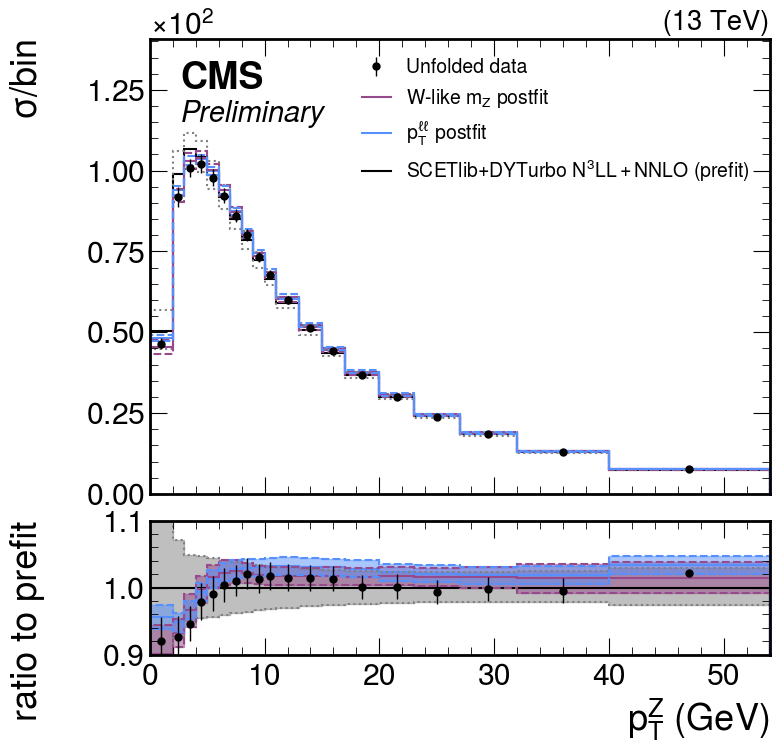

In [57]:
fig = plot_tools.makePlotWithRatioToRef(
                hists=[x.project("ptVGen" if "ptVGen" in x.axes.name else "ptVgen")[:54j] for x in [
                    gen_inc,
                    n3p0ll_ptlldatafith,
                    n3p0ll_wlikefith,
                    unfolding_inch,
                    theory_up,
                    theory_down,
                    wlikeup,
                    wlikedown,
                    ptllup,
                    ptlldown,
                ]],
                labels=[
                        r"SCETlib+DYTurbo N$^{3}LL+NNLO$ (prefit)",
                        r"$p_{T}^{\ell\ell}$ postfit",
                        r"W-like $m_{Z}$ postfit",
                        "Unfolded data",
                        "", "", 
                        "", "",
                        "", "",
                       ],
                colors=[
                        "black",
                        "#5790FC",
                        "#964A8B",
                        "black",
                        "gray",
                        "gray",
                        "#964A8B",
                        "#964A8B",
                        "#5790FC",
                        "#5790FC",
                       ],
                linestyles=["solid",]*4+["dotted"]*2+["dashed"]*4,
                xlabel="p$_{T}^{Z}$ (GeV)", 
                ylabel="$\sigma$/bin",
                rlabel=r"ratio to prefit",
                rrange=[0.9, 1.1],
                nlegcols=1,
                #legtext_size=22,
                yscale=1.2,
                xlim=None, binwnorm=1.0, baseline=True,
                yerr=False,
                fill_between=6,
                cms_label="Preliminary",
                legtext_size=14,
                dataIdx=3,
                scale_cms=0.8,
)
outdir = output_tools.make_plot_dir(out, "Z", eoscp=True)
name = "ptVgen_postfit_Wlike_RecoPtll_PrefitRatio_prelim"
plot_tools.save_pdf_and_png(outdir, name)
plot_tools.write_index_and_log(outdir, name)
output_tools.copy_to_eos(outdir, out, "Z", deleteFullTmp=True)

Wrote file(s) /tmp/tmp_93bs2a9/www/WMassAnalysis/PlotsForPaper/NaturePreCWR/Z//ptVgen_postfit_Wlike_RecoPtll_DataRatio_prelim.pdf(.png)


OSError: Failed to copy the files to eos! Perhaps you are missing a kerberos ticket and need to run kinit <user>@CERN.CH? from lxplus you can run without eoscp and take your luck with the mount.

[ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unauthorized identity used ; Permission denied

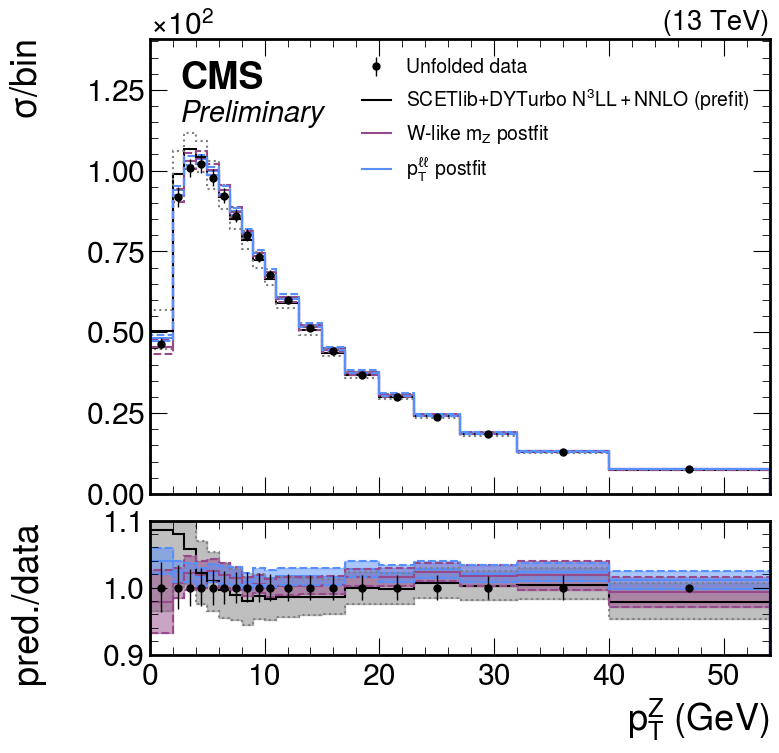

In [61]:
fig = plot_tools.makePlotWithRatioToRef(
                hists=[x.project("ptVGen" if "ptVGen" in x.axes.name else "ptVgen")[:54j] for x in [
                    unfolding_inch,     
                    n3p0ll_ptlldatafith,
                    n3p0ll_wlikefith,
                    gen_inc,
                    theory_up,
                    theory_down,
                    wlikeup,
                    wlikedown,
                    ptllup,
                    ptlldown,
                ]],
                labels=[
                        "Unfolded data",
                        r"$p_{T}^{\ell\ell}$ postfit",
                        r"W-like $m_{Z}$ postfit",
                        r"SCETlib+DYTurbo N$^{3}LL+NNLO$ (prefit)",
                        "", "", 
                        "", "",
                        "", "",
                       ],
                colors=[
                        "black",
                        "#5790FC",
                        "#964A8B",
                        "black",
                        "gray",
                        "gray",
                        "#964A8B",
                        "#964A8B",
                        "#5790FC",
                        "#5790FC",
                       ],
                linestyles=["solid",]*4+["dotted"]*2+["dashed"]*4,
                xlabel="p$_{T}^{Z}$ (GeV)", 
                ylabel="$\sigma$/bin",
                rlabel=f"pred./data",
                rrange=[0.9, 1.1],
                nlegcols=1,
                #legtext_size=22,
                yscale=1.2,
                xlim=None, binwnorm=1.0, baseline=True,
                yerr=False,
                fill_between=6,
                cms_label="Preliminary",
                legtext_size=14,
                dataIdx=0,
                scale_cms=0.8,
)
outdir = output_tools.make_plot_dir(out, "Z", eoscp=True)
name = "ptVgen_postfit_Wlike_RecoPtll_DataRatio_prelim"
plot_tools.save_pdf_and_png(outdir, name)
plot_tools.write_index_and_log(outdir, name)
output_tools.copy_to_eos(outdir, out, "Z", deleteFullTmp=True)

In [24]:
gen_inc_w = input_tools.read_all_and_scale("/scratch/submit/cms/wmass/histmaker_output_Aug19_fe51c5b/w_z_gen_dists_scetlib_dyturboCorr_maxFiles_m1_helicity_theorynom.hdf5", ["WminusmunuPostVFP", "WplusmunuPostVFP"], ["nominal_gen"])[0].project("ptVgen")[:100j]


In [25]:
mwfit = combinetf2_input.get_fitresult("/scratch/submit/cms/kdlong/CombineStudies/Unblinded/WGen_ptVgen/WGen_postfitFromUnblindedReco.hdf5")
ptllcombfit = combinetf2_input.get_fitresult("/scratch/submit/cms/kdlong/CombineStudies/Unblinded/WGen_ptVgen/WGen_postfitFromUnblindedPtllComb.hdf5")

In [ ]:
mwfit["hist_postfit_inclusive"]

In [26]:
mwfith = mwfit["hist_postfit_inclusive"]["ch0"].get()[:100j]/1000.
ptllcombfith = ptllcombfit["hist_postfit_inclusive"]["ch0"].get()[:100j]/1000.

In [27]:
ptllcombup, ptllcombdown = hist_to_up_down_unc(ptllcombfith)
mwup, mwdown = hist_to_up_down_unc(mwfith)

In [ ]:
mwfith

In [58]:
fig = plot_tools.makePlotWithRatioToRef(
                hists=[x[:54j] for x in [
                    gen_inc_w,
                    mwfith,
                    ptllcombfith,
                    mwup,
                    mwdown,
                    ptllcombup,
                    ptllcombdown,
                ]],
                labels=[
                        r"SCETlib+DYTurbo N$^{3}LL+NNLO$ (prefit)",
                        r"Combined W$+(p_{T}^{\ell\ell}, y^{\ell\ell})$ postfit",
                        r"W-only postfit",
                        "", "", 
                        "", "",
                       ],
                colors=[
                        "black",
                        "#5790FC",
                        "#E42536",
                        "#5790FC",
                        "#5790FC",
                        "#E42536",
                        "#E42536",
                       ],
                linestyles=["solid"]*3+["dashed"]*4,
                xlabel="p$_{T}^{W}$ (GeV)", 
                ylabel="$\sigma$/bin",
                rlabel=r"postfit/prefit",
                rrange=[0.9, 1.1],
                nlegcols=1,
                xlim=None, binwnorm=1.0, baseline=True,
                yerr=False,
                fill_between=4,
                cms_label=' ',
                yscale=1.2,
)
outdir = output_tools.make_plot_dir(out, "W", eoscp=True)
name = "ptVgen_postfit_RecoPtll_PrefitRatio"
plot_tools.save_pdf_and_png(outdir, name)
plot_tools.write_index_and_log(outdir, name)
output_tools.copy_to_eos(outdir, out, "W", deleteFullTmp=True)

NameError: name 'gen_inc_w' is not defined

In [38]:
fig = plot_tools.makePlotWithRatioToRef(
                hists=[
                    mwfith,
                    ptllcombfith,
                    gen_inc_w,
                    mwup,
                    mwdown,
                    ptllcombup,
                    ptllcombdown,
                ],
                labels=[
                        r"$p_{T}^{W}$ postfit",
                        r"$p_{T}^{W}$ postfit, $p_{T}^{\ell\ell}$ simult.",
                        r"Prefit N$^{3}LL+NNLO$",
                        "", "", 
                        "", "",
                       ],
                colors=[
                        "darkblue",
                        "darkgreen",
                        "darkred",
                        "darkblue",
                        "darkblue",
                        "darkgreen",
                        "darkgreen",
                       ],
                linestyles=["solid"]*2+["dashed"]+["solid"]*4,
                xlabel="p$_{T}^{W}$ (GeV)", 
                ylabel="$\sigma$/bin",
                rlabel=r"x/Nom. fit.",
                rrange=[0.9, 1.1],
                nlegcols=1,
                xlim=None, binwnorm=1.0, baseline=True,
                yerr=False,
                fill_between=4,
                yscale=1.2,
                cms_decorr=' ',
)
outdir = output_tools.make_plot_dir(out, "W", eoscp=True)
name = "ptVgen_postfit_RecoPtll_NominalRatio"
plot_tools.save_pdf_and_png(outdir, name)
plot_tools.write_index_and_log(outdir, name)
output_tools.copy_to_eos(outdir, out, "W", deleteFullTmp=True)

TypeError: makePlotWithRatioToRef() got an unexpected keyword argument 'cms_decorr'

In [ ]:
hh.divideHists(gen_inc, gen_inc_w)[:40j].plot()

In [ ]:
fig = plot_tools.makePlotWithRatioToRef(
                hists=[
                    hh.divideHists(gen_inc_w, gen_inc)[:40j],
                    hh.divideHists(mwfith, n3p0ll_ptlldatafith)[:40j],
                    hh.divideHists(ptllcombfith, n3p0ll_ptlldatafith)[:40j],
                ],
                labels=[
                        "Prefit",
                        "Nominal postfit",
                        "Combined postfit",
                       ],
                colors=[
                        "darkred",
                        "darkgreen",
                        "darkblue",
                       ],
                linestyles=["solid"]*2,
                xlabel="p$_{T}^{V}$ (GeV)", 
                ylabel="W/Z ratio",
                rlabel=r"x/prefit",
                rrange=[0.8, 1.2],
                nlegcols=1,
                ylim=[5, 15],
                xlim=None, baseline=True,
                yerr=False,
                fill_between=4,
)
outdir = output_tools.make_plot_dir(out, "W", eoscp=True)
name = "ptVgen_postfit_WZRatio"
plot_tools.save_pdf_and_png(outdir, name)
plot_tools.write_index_and_log(outdir, name)
output_tools.copy_to_eos(outdir, out, "W", deleteFullTmp=True)

In [ ]:
fig = plot_tools.makePlotWithRatioToRef(
                hists=[
                    hh.divideHists(mwfith, gen_inc_w),
                    hh.divideHists(n3p0ll_wlikefith, gen_inc),
                ],
                labels=[
                        "W",
                        "W-like Z",
                       ],
                colors=[
                        "darkgreen",
                        "darkblue",
                       ],
                linestyles=["solid"]*2,
                xlabel="p$_{T}^{V}$ (GeV)", 
                ylabel="postfit/prefit ratio",
                rlabel=r"W-like/W",
                rrange=[0.8, 1.2],
                nlegcols=1,
                ylim=[0.8, 1.2],
                xlim=None, baseline=True,
                yerr=False,
                fill_between=4,
)
outdir = output_tools.make_plot_dir(out, "W", eoscp=True)
name = "ptVgen_postfit_WZCompare"
plot_tools.save_pdf_and_png(outdir, name)
plot_tools.write_index_and_log(outdir, name)
output_tools.copy_to_eos(outdir, out, "W", deleteFullTmp=True)